Deadline: 23.11.2021 23:59

# Домашнее задание

1. Для датасета животных обучить MLP.
2. Использовать Custom Dataset, Sampler, collate_fn
3. Сделать различную предобработку фичей
4. Подключить для логирования tensorboard и/или mlflow
5. Не забыть разделить выборку на train и valid
6. Получить точность не ниже 65%.

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import random
import gc

import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch

print(torch.__version__)

import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

from torch.utils.data import DataLoader, Dataset, Sampler
from torch.utils.data.dataloader import default_collate
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

1.10.0+cu113


In [2]:
# Fix random seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
# Make device report
print(
"CUDA is available: {}\n\
CUDA version: {}\n\
CUDA devices count: {}\n\
CUDA device name: {}".format(
                                torch.cuda.is_available(),
                                torch.cuda_version,
                                torch.cuda.device_count(),
                                torch.cuda.get_device_name(0)
                            )
)

CUDA is available: True
CUDA version: 11.3
CUDA devices count: 1
CUDA device name: NVIDIA GeForce MX150


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

## Part 1. Analyse data

In [4]:
data = pd.read_csv('./data/X_cat.csv', sep='\t', index_col=0)

In [5]:
# Check if data features are categorical
if (data.Sex_Female + data.Sex_Male + data.Sex_Unknown).unique()[0] == 1: print("Sex is categorical") 
if (data.SexStatus_Flawed + data.SexStatus_Intact + data.SexStatus_Unknown).unique()[0] == 1: print("SexStatus is categorical")

if (data['Breed_Chihuahua Shorthair Mix']+data['Breed_Domestic Medium Hair Mix']+data['Breed_Domestic Shorthair Mix'] \
   +data['Breed_German Shepherd Mix']+data['Breed_Labrador Retriever Mix']+data['Breed_Pit Bull Mix']+data['Breed_Rare']).unique()[0] == 1:
   print('Breed is categorical')

Sex is categorical
SexStatus is categorical
Breed is categorical


In [6]:
weekday_columns = [
    'Weekday_0',
    'Weekday_1',
    'Weekday_2',
    'Weekday_3',
    'Weekday_4',
    'Weekday_5',
    'Weekday_6'
]
        
weekdays = np.argmax(data[weekday_columns].values, axis=1)

data.drop(weekday_columns, axis=1, inplace=True)

# Cycle features recalc with sine and cosine
data['Weekday_cos'] = np.cos((2 * np.pi / 7.) * weekdays)
data['Weekday_sin'] = np.sin((2 * np.pi / 7.) * weekdays)

data['Hour_cos'] = np.cos((2 * np.pi / 24.) * data['Hour'].values)
data['Hour_sin'] = np.sin((2 * np.pi / 24.) * data['Hour'].values)

data['Month_cos'] = np.cos((2 * np.pi / 12.) * data['Month'].values)
data['Month_sin'] = np.sin((2 * np.pi / 12.) * data['Month'].values)

data.drop(['Hour', 'Month'], axis=1, inplace=True)

# Gender as categorical (embedding in future)
data['Gender'] = np.argmax(data[['Sex_Female', 'Sex_Male', 'Sex_Unknown']].values, axis=1)
data['SexStatus'] = np.argmax(data[['SexStatus_Flawed', 'SexStatus_Intact', 'SexStatus_Unknown']].values, axis=1)

breed_ftrs = [
    'Breed_Chihuahua Shorthair Mix',
    'Breed_Domestic Medium Hair Mix',
    'Breed_Domestic Shorthair Mix',
    'Breed_German Shepherd Mix',
    'Breed_Labrador Retriever Mix',
    'Breed_Pit Bull Mix',
    'Breed_Rare']
data['Breed'] = np.argmax(data[breed_ftrs].values, axis=1)

data.drop(['Sex_Female', 'Sex_Male', 'Sex_Unknown'], axis=1, inplace=True)
data.drop(['SexStatus_Flawed', 'SexStatus_Intact', 'SexStatus_Unknown'], axis=1, inplace=True)
data.drop(breed_ftrs, axis=1, inplace=True)

In [7]:
data.columns

Index(['IsDog', 'Age', 'HasName', 'NameLength', 'NameFreq', 'MixColor',
       'ColorFreqAsIs', 'ColorFreqBase', 'TabbyColor', 'MixBreed', 'Domestic',
       'Shorthair', 'Longhair', 'Year', 'Day', 'Weekday_cos', 'Weekday_sin',
       'Hour_cos', 'Hour_sin', 'Month_cos', 'Month_sin', 'Gender', 'SexStatus',
       'Breed'],
      dtype='object')

Now let's look for insights

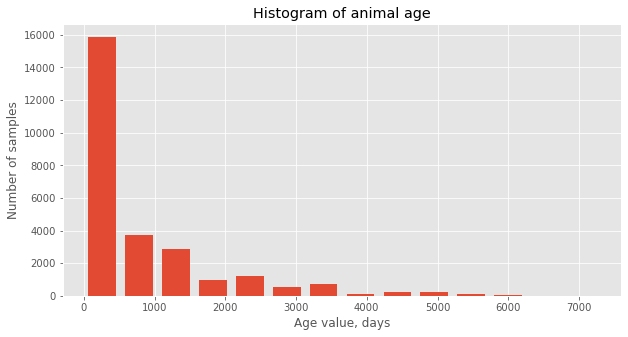

In [8]:
# Let's look on animal age. Seems to be lognorm-distributed
plt.figure(figsize=(10,5))
plt.title("Histogram of animal age")
plt.hist(data.Age, bins=14, rwidth=0.75)
plt.xlabel("Age value, days")
plt.ylabel("Number of samples")
plt.show()

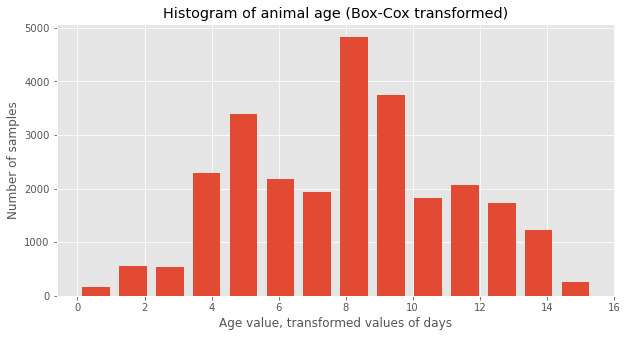

In [9]:
# Let's now look at Box-Cox transformed values distribution
plt.figure(figsize=(10,5))
plt.title("Histogram of animal age (Box-Cox transformed)")
plt.hist(stats.boxcox(data.Age)[0], bins=14, rwidth=0.75)
plt.xlabel("Age value, transformed values of days")
plt.ylabel("Number of samples")
plt.show()

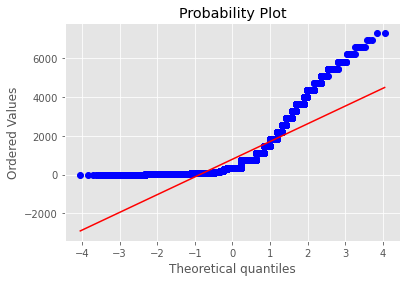

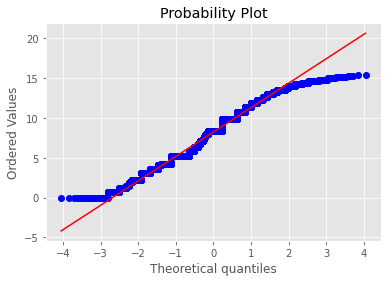

In [10]:
# Looks much better. Q-Q plot is the evidence
stats.probplot(data.Age, dist="norm", plot=plt)
plt.show()
  
stats.probplot(stats.boxcox(data.Age)[0], dist="norm", plot=plt)
plt.show()

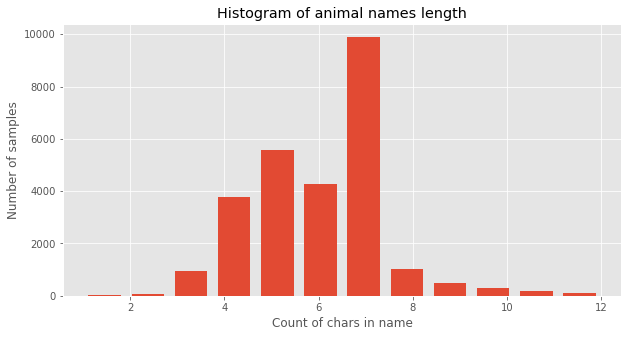

In [11]:
# Animal name length
plt.figure(figsize=(10,5))
plt.title("Histogram of animal names length")
plt.hist(data.NameLength, bins=12, rwidth=0.75)
plt.xlabel("Count of chars in name")
plt.ylabel("Number of samples")
plt.show()

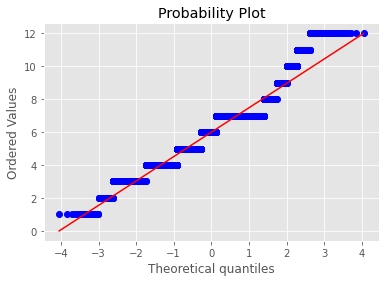

In [12]:
# Allright. We won't change this feature  
stats.probplot(data.NameLength, dist="norm", plot=plt)
plt.show()

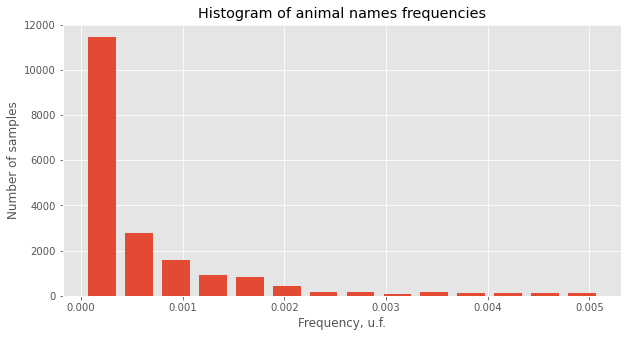

In [13]:
# Animal name frequency (for animals with names only)
plt.figure(figsize=(10,5))
plt.title("Histogram of animal names frequencies")
plt.hist(data[data.HasName != 0].NameFreq, bins=14, rwidth=0.75)
plt.xlabel("Frequency, u.f.")
plt.ylabel("Number of samples")
plt.show()

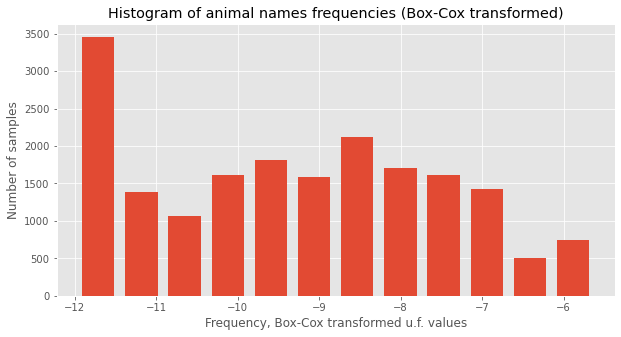

In [14]:
# Animal name frequency (for animals with names only)
plt.figure(figsize=(10,5))
plt.title("Histogram of animal names frequencies (Box-Cox transformed)")
plt.hist(stats.boxcox(data[data.HasName != 0].NameFreq)[0], bins=12, rwidth=0.75)
plt.xlabel("Frequency, Box-Cox transformed u.f. values")
plt.ylabel("Number of samples")
plt.show()

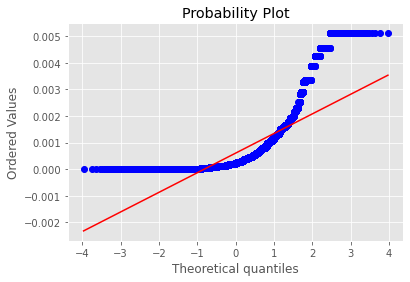

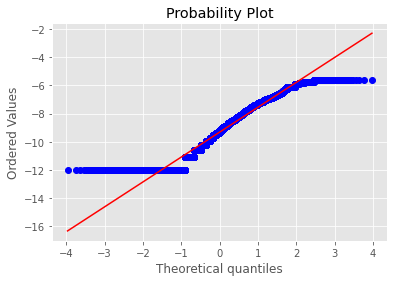

In [15]:
# Well, not as good as expected, still it is now less logarithmic in 0 point neighborhood
stats.probplot(data[data.HasName != 0].NameFreq, dist="norm", plot=plt)
plt.show()
stats.probplot(stats.boxcox(data[data.HasName != 0].NameFreq)[0], dist="norm", plot=plt)
plt.show()

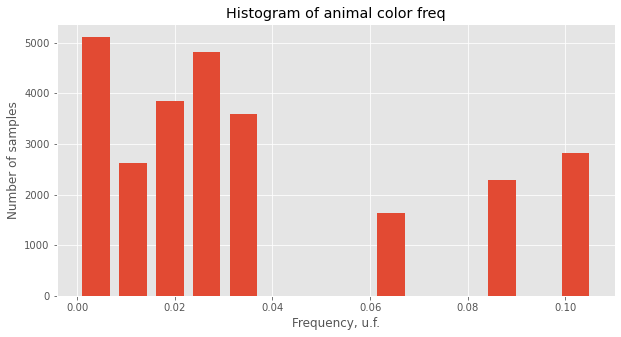

In [16]:
# Animal color freq as is. Not obvious, actually, I won't touch it
plt.figure(figsize=(10,5))
plt.title("Histogram of animal color freq")
plt.hist(data.ColorFreqAsIs, bins=14, rwidth=0.75)
plt.xlabel("Frequency, u.f.")
plt.ylabel("Number of samples")
plt.show()

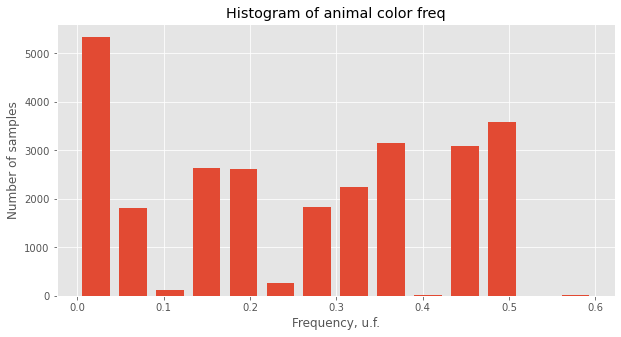

In [17]:
# Animal color freq base. Also not obvious, actually, I won't touch it
plt.figure(figsize=(10,5))
plt.title("Histogram of animal color freq")
plt.hist(data.ColorFreqBase, bins=14, rwidth=0.75)
plt.xlabel("Frequency, u.f.")
plt.ylabel("Number of samples")
plt.show()

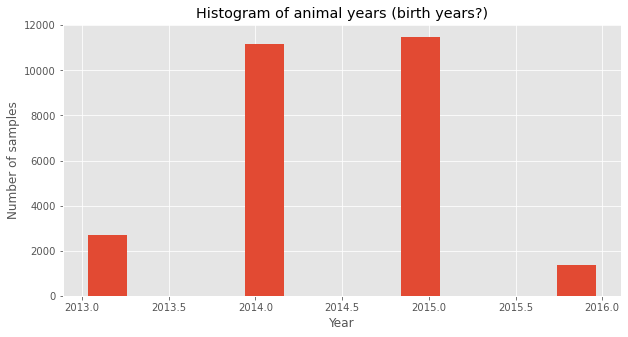

In [18]:
# Actually, it is a discrete distribution with 4 values only.
# It seems, that it could be normal (less values on edges), still it is discrete, so I won't touch it
plt.figure(figsize=(10,5))
plt.title("Histogram of animal years (birth years?)")
plt.hist(data.Year, rwidth=0.75)
plt.xlabel("Year")
plt.ylabel("Number of samples")
plt.show()

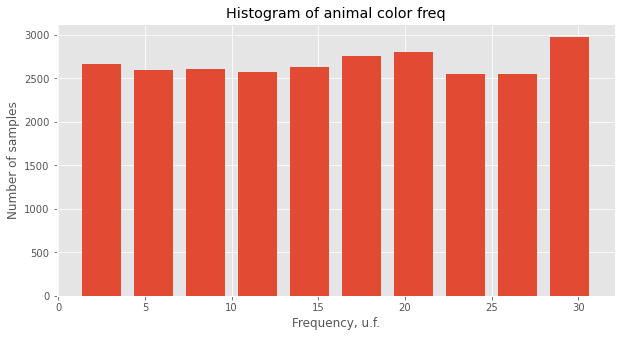

In [19]:
# Distribution actually is close to uniform. I won't touch it
plt.figure(figsize=(10,5))
plt.title("Histogram of animal color freq")
plt.hist(data.Day, rwidth=0.75)
plt.xlabel("Frequency, u.f.")
plt.ylabel("Number of samples")
plt.show()

In [20]:
del data
del breed_ftrs
del weekday_columns
del weekdays

gc.collect()

40519

**So what we have:**
1. United breed, sexstatus and sex as unique categorical features
2. Features shifted to normal distribution where it is possible

## Part 2. Build and train neural network

In [37]:
train_writer = SummaryWriter('./logs/train')
valid_writer = SummaryWriter('./logs/valid')

In [38]:
class CustomDataset(Dataset):
    """
    Allows to read "Animal dataset" data from given .csv files (X and y),
    split them as train:valid:test = 70:20:10,
    rebuild features in terms of their nature (cycle, categorical, numeric etc),
    provides an iterable over the given dataframe

    Args:
        X_path (str): path to Samples-Features matrix data
        y_path (str): path to targets
        flag (str): defines possible regimes of class-object working:
            train - train data are iterated
            valid: - validation data are iterated
            test: - test data are iterated
        device: device which is used for model training
    

    Returns (call __getitem__):
        tuple: tuple with elements:
            0 - dictionary with structure {feature_name: sample_value}
            1 - target value
    """
    
    # Read dataset
    def __init__(self, X_path: str, y_path: str, flag: str, device: device):
        
        # Check types of variables
        if type(X_path) != str or type(y_path) != str or type(flag) != str:
            raise TypeError("path could be string only")
        
        # Load data
        X = pd.read_csv(X_path, sep='\t', index_col=0)
        y = pd.read_csv(y_path, sep='\t', index_col=0, names=['status'])  # header=-1,


        # Samples-Features matrix preprocessing
        # Weekdays as numbers
        weekday_columns = [
            'Weekday_0',
            'Weekday_1',
            'Weekday_2',
            'Weekday_3',
            'Weekday_4',
            'Weekday_5',
            'Weekday_6'
            ]
        
        weekdays = np.argmax(X[weekday_columns].values, axis=1)

        X.drop(weekday_columns, axis=1, inplace=True)


        # Cycle features recalc with sine and cosine
        X['Weekday_cos'] = np.cos((2 * np.pi / 7.) * weekdays)
        X['Weekday_sin'] = np.sin((2 * np.pi / 7.) * weekdays)

        X['Hour_cos'] = np.cos((2 * np.pi / 24.) * X['Hour'].values)
        X['Hour_sin'] = np.sin((2 * np.pi / 24.) * X['Hour'].values)

        X['Month_cos'] = np.cos((2 * np.pi / 12.) * X['Month'].values)
        X['Month_sin'] = np.sin((2 * np.pi / 12.) * X['Month'].values)

        X.drop(['Hour', 'Month'], axis=1, inplace=True)


        # Gender, SexStatus and Breed as categorical (embedding in future)
        X['Gender'] = np.argmax(X[['Sex_Female', 'Sex_Male', 'Sex_Unknown']].values, axis=1)
        X['SexStatus'] = np.argmax(X[['SexStatus_Flawed', 'SexStatus_Intact', 'SexStatus_Unknown']].values, axis=1)

        breed_ftrs = [
            'Breed_Chihuahua Shorthair Mix',
            'Breed_Domestic Medium Hair Mix',
            'Breed_Domestic Shorthair Mix',
            'Breed_German Shepherd Mix',
            'Breed_Labrador Retriever Mix',
            'Breed_Pit Bull Mix',
            'Breed_Rare']
        X['Breed'] = np.argmax(X[breed_ftrs].values, axis=1)

        X.drop(['Sex_Female', 'Sex_Male', 'Sex_Unknown'], axis=1, inplace=True)
        X.drop(['SexStatus_Flawed', 'SexStatus_Intact', 'SexStatus_Unknown'], axis=1, inplace=True)
        X.drop(breed_ftrs, axis=1, inplace=True)


        # Box-Cox transform to shift data to normal distribution
        X.Age = stats.boxcox(X.Age)[0]
        X[X.HasName != 0].NameFreq = stats.boxcox(X[X.HasName != 0].NameFreq)[0]


        # Define features' categories
        self.column_names = X.columns.values

        self.embedding_columns = ['Gender', 'SexStatus', 'Breed']
        self.emb_categories = [3, 7]
        self.numeric_columns = ['IsDog', 'Age', 'HasName', 'NameLength', 'NameFreq', 'MixColor', 'ColorFreqAsIs',
                                'ColorFreqBase', 'TabbyColor', 'MixBreed', 'Domestic', 'Shorthair', 'Longhair',
                                'Year', 'Day',  'Weekday_cos', 'Weekday_sin', 'Hour_cos', 'Hour_sin',
                                'Month_cos', 'Month_sin']


        # Target preprocessing
        target = y.iloc[:, :].values
        target[target == 'Died'] = 'Euthanasia'

        le = LabelEncoder()
        target = le.fit_transform(target)


        # Make train-valid-test split
        X_buf, X_test, y_buf, y_test = train_test_split(X, target, test_size=0.1, random_state=0)
        X_train, X_val, y_train, y_val = train_test_split(X_buf, y_buf, test_size=2/9, random_state=0)

  
        if flag == "train":
            self.X = X_train.values
            self.y = torch.tensor(y_train).type(torch.LongTensor).to(device)
        elif flag == "valid":
            self.X = X_val.values
            self.y = torch.tensor(y_val).type(torch.LongTensor).to(device)
        elif flag == "test":
            self.X = X_test.values
            self.y = torch.tensor(y_test).type(torch.LongTensor).to(device)
        else:
            raise ValueError("Incorrect flag value")


    def __len__(self):
        return len(self.X)


    # __getitem__ method overriding
    def __getitem__(self, idx):

        row = self.X[idx, :]
        row = {col: torch.tensor(row[i]) for i, col in enumerate(self.column_names)}

        for emb_col in self.embedding_columns:
            row[emb_col] = torch.tensor(row[emb_col]).type(torch.IntTensor).to(device)

        return row, self.y[idx]

In [39]:
class MLPNet(nn.Module):
    """
    Allows to initialize multilayer perceptron as MLPNet object and get target values through forward method
    Args:
        __init__
            input_size (int): input number of neurons (input vector dim)
            hidden_size (int): number of neurons in hidden layers
            nrof_sex (int): number of sex/sex status categories
            nrof_breed (int): number of breed categories
            emb_dim_sex (int): size of embedding for sex/sex status
            emb_dim_breed (int): size of embedding for breed
            emb_columns (list): list of embedding features names
            numeric_columns (list): list of numeric features names

        init_weights
            m (nn.Linear): linear layer that we wish weights be initialized
        
        forward
            x (dict): dict of features for forward-values calculations (not activated)
        
        predict
            x (dict): dict of features for class label predictions
        
        predict_proba
            x (dict): dict of features for class probabilities estimation
    """

    def __init__(
        self, input_size: int,
        hidden_size: int,
        output_size: int,
        nrof_sex: int,
        nrof_breed: int,
        emb_dim_sex: int,
        emb_dim_breed: int,
        emb_columns: list,
        numeric_columns: list):

        super(MLPNet, self).__init__()
        
        self.emb_columns = emb_columns
        self.numeric_columns = numeric_columns

        # Embedding layers
        self.emb_layers = nn.ModuleDict()
        for emb_column in self.emb_columns:
            if emb_column == 'Breed':
                self.emb_layers[emb_column] = nn.Embedding(nrof_breed, emb_dim_breed)
                continue
            self.emb_layers[emb_column] = nn.Embedding(nrof_sex, emb_dim_sex)

        # Common layers
        self.feature_bn = nn.BatchNorm1d(input_size)

        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear1.apply(self.init_weights)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.act = nn.LeakyReLU(0.1)

        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear2.apply(self.init_weights)
        self.bn2 = nn.BatchNorm1d(hidden_size)

        self.linear3 = nn.Linear(hidden_size, output_size)
        
        self.sm = torch.nn.Softmax(dim=1)

    def init_weights(self, m: nn.Linear):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform(m.weight)
            # m.bias.data.fill_(0.001)


    def forward(self, x: dict, device):
        
        # Calculate embeddings, take numerics
        embeddings = None

        for emb_column in self.emb_columns:
            if embeddings is None:
                embeddings = self.emb_layers[emb_column](x[emb_column])
                x.pop(emb_column, None)
                continue
            
            temp_emb = self.emb_layers[emb_column](x[emb_column])
            x.pop(emb_column, None)
            embeddings = torch.cat((embeddings, temp_emb), dim=1)

        numeric_feats = torch.tensor(pd.DataFrame(x)[self.numeric_columns].values, dtype=torch.float32).to(device)

        # Unite features
        concat_input = torch.cat([numeric_feats, embeddings], dim=1)
        output = self.feature_bn(concat_input)

        # Calculate outputs
        output = self.linear1(output)
        output = self.bn1(output)
        output = self.act(output)

        output = self.linear2(output)
        output = self.bn2(output)
        output = self.act(output)

        output = self.linear3(output)

        return output

    def predict(self, x: dict):
        # predict class-label as number
        return self.forward(x).argmax(dim=1)

    def predict_proba(self, x: dict):
        # predict class-labels probabilities
        x = self.forward(x)
        x = self.sm(x)
        return x

In [40]:
# GLOBALS: hyperparameters

INPUT_SIZE = 40
HIDDEN_SIZE = 32
OUTPUT_SIZE = 5
LEARNING_RATE = 3e-4
EPOCHS = 100
BATCH_SIZE = 64
EMB_SIZE_SEX = 5
EMB_SIZE_BREED = 9

In [41]:
# Make train, validation and test datasets
animal_ds_train = CustomDataset('./data/X_cat.csv', './data/y_cat.csv', 'train', device)
animal_ds_valid = CustomDataset('./data/X_cat.csv', './data/y_cat.csv', 'valid', device)
animal_ds_test = CustomDataset('./data/X_cat.csv', './data/y_cat.csv', 'test', device)

# Make data loaders for train and validation stages
train_loader = data_utils.DataLoader(
    dataset=animal_ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True)

valid_loader = data_utils.DataLoader(
    dataset=animal_ds_valid,
    batch_size=1,
    shuffle=False)

# Initialize model
mlpnet = MLPNet(
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    animal_ds_train.emb_categories[0],
    animal_ds_train.emb_categories[1],
    EMB_SIZE_SEX,
    EMB_SIZE_BREED,
    animal_ds_train.embedding_columns,
    animal_ds_train.numeric_columns)

# GLOBALS: loss, optimizer, metrics

criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()

optimizer = optim.Adam(mlpnet.parameters(), lr=LEARNING_RATE)

In [42]:
# History parameters
history = {
    'train_loss_values': [],
    'train_accuracy_values': [],
    'valid_loss_values': [],
    'valid_accuracy': []}

In [43]:
# Train loop

# Move to device
mlpnet = mlpnet.to(device)
criterion = criterion.to(device)
accuracy.to(device)

step = 0
val_step = 0

for epoch in range(EPOCHS):
    mlpnet.train() # train stage

    running_loss = []

    for features, label in train_loader:
        # Reset gradients
        optimizer.zero_grad()

        # Compute forwardprop through net
        output = mlpnet.forward(features, device)
            
        # Calculate error and backpropagate
        loss = criterion(output, label)
        loss.backward()
        acc = accuracy(output, label)

        # Update weights with gradients
        optimizer.step()
            
        step += 1
        
        # Log train loss and metrics to tensorboard
        train_writer.add_scalar('CrossEntropyLoss', loss.item(), step)
        train_writer.add_scalar('Accuracy', acc.item(), step)

        running_loss.append(loss.item())

    acc_train = accuracy.compute()
    accuracy.reset()

    history['train_loss_values'].append(np.mean(running_loss))
    history['train_accuracy_values'].append(acc_train)


    mlpnet.eval() # evaluation stage

    running_val_loss = []

    for features, label in valid_loader:
        # Compute current loss and accuracy
        output = mlpnet.forward(features, device)
        val_loss = criterion(output, label)
        val_acc = accuracy(output, label)
            
        val_step += 1

        # Log valid loss and metrics to tensorboard
        valid_writer.add_scalar('CrossEntropyLoss', val_loss.item(), val_step)
        valid_writer.add_scalar('Accuracy', val_acc.item(), val_step)

        running_val_loss.append(val_loss.item())

    acc_val = accuracy.compute()
    accuracy.reset()

    history['valid_loss_values'].append(np.mean(running_val_loss))
    history['valid_accuracy'].append(acc_val.item())
    
    if epoch % 10 == 0:
        print('EPOCH %d : train_loss: %f, train accuracy: %f. Validation: val_loss: %f, val_acc: %f'
        %(epoch, np.mean(running_loss), acc_train, np.mean(running_val_loss), acc_val))
        torch.save(mlpnet, './models/mlpnet_{}.pth'.format(str(epoch)))

EPOCH 0 : train_loss: 1.260923, train accuracy: 0.501871. Validation: val_loss: 1.023854, val_acc: 0.619903
EPOCH 10 : train_loss: 0.813729, train accuracy: 0.660449. Validation: val_loss: 0.805426, val_acc: 0.661055
EPOCH 20 : train_loss: 0.788348, train accuracy: 0.670818. Validation: val_loss: 0.786997, val_acc: 0.666293
EPOCH 30 : train_loss: 0.776481, train accuracy: 0.673650. Validation: val_loss: 0.782442, val_acc: 0.666480
EPOCH 40 : train_loss: 0.771336, train accuracy: 0.677712. Validation: val_loss: 0.780291, val_acc: 0.667228
EPOCH 50 : train_loss: 0.761878, train accuracy: 0.681026. Validation: val_loss: 0.776060, val_acc: 0.668350
EPOCH 60 : train_loss: 0.754248, train accuracy: 0.683218. Validation: val_loss: 0.773755, val_acc: 0.672091
EPOCH 70 : train_loss: 0.752257, train accuracy: 0.684981. Validation: val_loss: 0.774293, val_acc: 0.672840
EPOCH 80 : train_loss: 0.748524, train accuracy: 0.685088. Validation: val_loss: 0.777011, val_acc: 0.669285
EPOCH 90 : train_los

Text(0, 0.5, 'Loss value')

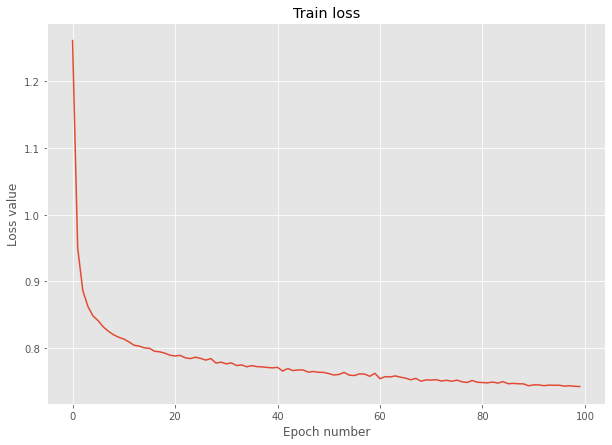

In [49]:
plt.figure(figsize=(10, 7))
plt.plot(history['train_loss_values'])
plt.title('Train loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss value')

Text(0, 0.5, 'Accuracy value')

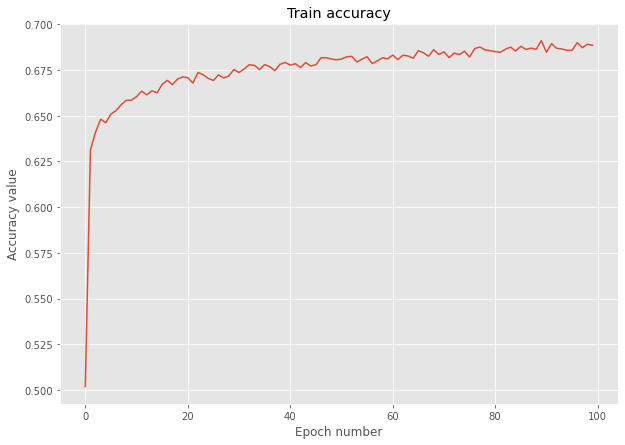

In [50]:
plt.figure(figsize=(10, 7))
plt.plot(history['train_accuracy_values'])
plt.title('Train accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy value')

Text(0, 0.5, 'Loss value')

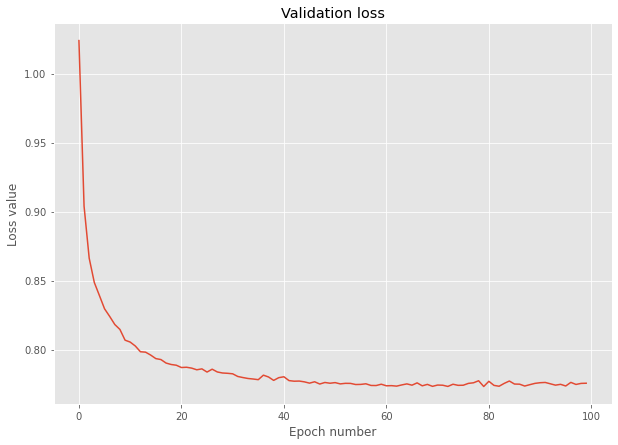

In [52]:
plt.figure(figsize=(10, 7))
plt.plot(history['valid_loss_values'])
plt.title('Validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss value')

Text(0, 0.5, 'Accuracy value')

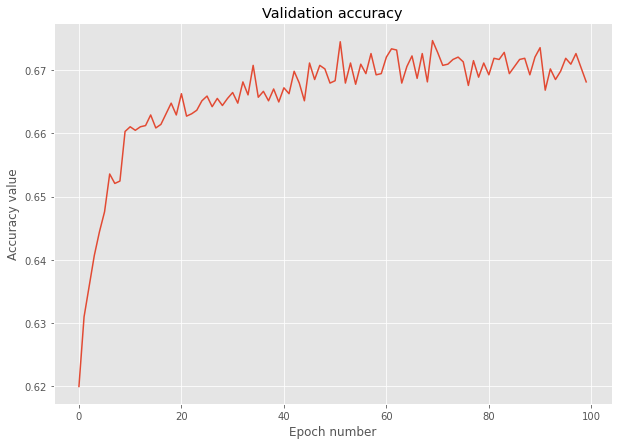

In [53]:
plt.figure(figsize=(10, 7))
plt.plot(history['valid_accuracy'])
plt.title('Validation accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy value')

In [60]:
# Create test data loader
test_loader = data_utils.DataLoader(
    dataset=animal_ds_test,
    batch_size=1,
    shuffle=False)

In [61]:
# Final test
running_test_loss = []

for features, label in test_loader:
    output = mlpnet.forward(features, device)
    test_loss = criterion(output, label)
    accuracy(output, label)
            
    running_test_loss.append(test_loss.item())

acc_test = accuracy.compute()
accuracy.reset()


print("Final test: Loss value = {}, Accuracy on test = {}".format(np.mean(running_test_loss), acc_test.item()))

Final test: Loss value = 0.7683402385774846, Accuracy on test = 0.680134654045105
